# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob


# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))


Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

train_humans = human_files[:6680]
valid_humans = human_files[6681:7516]
test_humans = human_files[7517:8353]

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))
print('')
print("Number of humans split into the training set:", len(train_humans))
print('')
print('Number of humans split into the validation set:', len(valid_humans))
print('')
print('Number of humans split into the test set:', len(test_humans))


There are 13233 total human images.

Number of humans split into the training set: 6680

Number of humans split into the validation set: 835

Number of humans split into the test set: 836


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


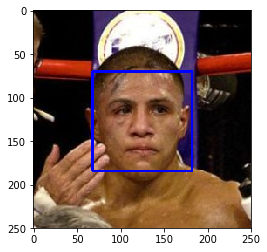

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
face_cascade2 = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')
face_cascade_default = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
face_cascade_profile = cv2.CascadeClassifier('haarcascades/haarcascade_profileface.xml')
left_eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_lefteye_2splits.xml')
right_eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_righteye_2splits.xml')
smile_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_smile.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])

# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image"
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
- 98% of the first 100 images in 'human_files' have a detected human face.
- 11% of the first 100 dog images in 'dog_files' have a detected human face.

In [4]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

In [6]:
humans_detected = [face_detector(human_files_short[i]) for i in range(len(human_files_short))]
humans_in_dogs = [face_detector(dog_files_short[i]) for i in range(len(dog_files_short))]

print("Number of humans faces detected in first 100 human images:", humans_detected.count(True))
print('')
print("Number of humans faces detected in first 100 dog images:", humans_in_dogs.count(True))

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

Number of humans faces detected in first 100 human images: 98

Number of humans faces detected in first 100 dog images: 11


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ It is not reasonable to expect a complete view of the face because real people, amateur photo-takers, do not always take pictures where the face of everyone is completely visible. The face detector algorithm should be able to detect distinctive human features such as human eyes, nose, lips, and smile, and more to output 'True' for the presence of a human face.


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [7]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.
def face_detector2(img_path):
    global img
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    right_eye = right_eye_cascade.detectMultiScale(gray)
    left_eye = left_eye_cascade.detectMultiScale(gray)
    smile = smile_cascade.detectMultiScale(gray)
    return (len(faces) > 0) or (len(left_eye) > 0) or (len(right_eye) > 0) or (len(smile) > 0)
    
humans_detected = [face_detector(human_files[i]) for i in range(len(human_files[:250]))]
humans_detected2 = [face_detector2(human_files[i]) for i in range(len(human_files[:250]))]
false_pos = [face_detector2(train_files[i]) for i in range(len(train_files[:250]))]

print('Number of human faces detected by first face detector out of 250 human images:', humans_detected.count(True))
print('')
print ("Number of human faces detected by second face detector out of 250 human images:", humans_detected2.count(True))
print('')
print('False Positives: number of human faces detected in 250 dog images:', false_pos.count(True))

Number of human faces detected by first face detector out of 250 human images: 245

Number of human faces detected by second face detector out of 250 human images: 250

False Positives: number of human faces detected in 250 dog images: 250


In [8]:
def face_detector3(img_path): 
    global img
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade2.detectMultiScale(gray)
    return len(faces) > 0

humans_detected = [face_detector3(human_files_short[i]) for i in range(len(human_files_short))]
humans_in_dogs = [face_detector3(dog_files_short[i]) for i in range(len(dog_files_short))]

print("Number of humans faces detected in first 100 human images:", humans_detected.count(True))
print('')
print("Number of humans faces detected in first 100 dog images:", humans_in_dogs.count(True))

   

Number of humans faces detected in first 100 human images: 99

Number of humans faces detected in first 100 dog images: 20


In [9]:
def face_detector4(img_path): 
    global img
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade_default.detectMultiScale(gray)
    return len(faces) > 0

humans_detected = [face_detector4(human_files_short[i]) for i in range(len(human_files_short))]
humans_in_dogs = [face_detector4(dog_files_short[i]) for i in range(len(dog_files_short))]

print("Number of humans faces detected in first 100 human images:", humans_detected.count(True))
print('')
print("Number of humans faces detected in first 100 dog images:", humans_in_dogs.count(True))

Number of humans faces detected in first 100 human images: 100

Number of humans faces detected in first 100 dog images: 57


In [10]:
def face_detector5(img_path): 
    global img
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade_profile.detectMultiScale(gray)
    return len(faces) > 0

humans_detected = [face_detector5(human_files_short[i]) for i in range(len(human_files_short))]
humans_in_dogs = [face_detector5(dog_files_short[i]) for i in range(len(dog_files_short))]

print("Number of humans faces detected in first 100 human images:", humans_detected.count(True))
print('')
print("Number of humans faces detected in first 100 dog images:", humans_in_dogs.count(True))

Number of humans faces detected in first 100 human images: 42

Number of humans faces detected in first 100 dog images: 2


In [43]:
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [44]:
import random
random.seed(8675309)

total_train = np.concatenate((train_humans, train_files), axis=0)
random.shuffle(total_train)
total_valid = np.concatenate((valid_humans, valid_files), axis=0)
random.shuffle(total_valid)
total_test = np.concatenate((test_humans, test_files), axis=0)
random.shuffle(total_test)

total_train_targets = []
for i in total_train:
    if i[:3] == 'lfw':
        total_train_targets.append([1., 0.])
    else:
        total_train_targets.append([0., 1.])
DvH_train_targets = np.array(total_train_targets)

total_valid_targets = []
for i in total_valid:
    if i[:3] == 'lfw':
        total_valid_targets.append([1., 0.])
    else:
        total_valid_targets.append([0., 1.])
DvH_valid_targets = np.array(total_valid_targets)

total_test_targets = []
for i in total_test:
    if i[:3] == 'lfw':
        total_test_targets.append([1., 0.])
    else:
        total_test_targets.append([0., 1.])
DvH_test_targets = np.array(total_test_targets)


DvH_train = paths_to_tensor(total_train)
DvH_valid = paths_to_tensor(total_valid)
DvH_test = paths_to_tensor(total_test)



  0%|          | 0/13360 [00:00<?, ?it/s]

  0%|          | 21/13360 [00:00<01:06, 200.03it/s]

  0%|          | 31/13360 [00:00<01:42, 130.29it/s]

  0%|          | 52/13360 [00:00<01:27, 152.57it/s]

  1%|          | 84/13360 [00:00<01:10, 187.91it/s]

  1%|          | 115/13360 [00:00<01:03, 209.79it/s]

  1%|          | 136/13360 [00:00<01:05, 203.13it/s]

  1%|▏         | 167/13360 [00:00<01:00, 216.91it/s]

  2%|▏         | 204/13360 [00:00<00:56, 233.27it/s]

  2%|▏         | 232/13360 [00:00<00:55, 237.44it/s]

  2%|▏         | 259/13360 [00:01<01:00, 216.86it/s]

  2%|▏         | 282/13360 [00:01<01:01, 212.29it/s]

  2%|▏         | 311/13360 [00:01<00:59, 217.54it/s]

  3%|▎         | 337/13360 [00:01<00:59, 220.24it/s]

  3%|▎         | 362/13360 [00:01<00:58, 221.09it/s]

  3%|▎         | 386/13360 [00:01<00:58, 221.82it/s]

  3%|▎         | 419/13360 [00:01<00:56, 227.56it/s]

  3%|▎         | 450/13360 [00:01<00:55, 231.76it/s]

  4%|▎         | 478/13360 [00:02<00:55, 

 27%|██▋       | 3626/13360 [00:17<00:47, 206.08it/s]

 27%|██▋       | 3649/13360 [00:17<00:47, 206.19it/s]

 28%|██▊       | 3678/13360 [00:17<00:46, 206.53it/s]

 28%|██▊       | 3702/13360 [00:17<00:46, 206.71it/s]

 28%|██▊       | 3726/13360 [00:18<00:46, 206.30it/s]

 28%|██▊       | 3748/13360 [00:18<00:46, 205.10it/s]

 28%|██▊       | 3779/13360 [00:18<00:46, 205.64it/s]

 28%|██▊       | 3801/13360 [00:18<00:46, 205.71it/s]

 29%|██▊       | 3823/13360 [00:18<00:46, 205.37it/s]

 29%|██▉       | 3853/13360 [00:18<00:46, 205.83it/s]

 29%|██▉       | 3876/13360 [00:18<00:46, 205.41it/s]

 29%|██▉       | 3904/13360 [00:18<00:46, 205.55it/s]

 29%|██▉       | 3926/13360 [00:19<00:46, 204.82it/s]

 30%|██▉       | 3945/13360 [00:19<00:45, 204.74it/s]

 30%|██▉       | 3964/13360 [00:19<00:45, 204.57it/s]

 30%|██▉       | 3991/13360 [00:19<00:45, 204.90it/s]

 30%|███       | 4012/13360 [00:19<00:45, 204.84it/s]

 30%|███       | 4042/13360 [00:19<00:45, 205.31it/s]

 30%|███  

 53%|█████▎    | 7125/13360 [00:34<00:30, 204.42it/s]

 54%|█████▎    | 7149/13360 [00:35<00:30, 204.17it/s]

 54%|█████▎    | 7171/13360 [00:35<00:30, 204.05it/s]

 54%|█████▍    | 7192/13360 [00:35<00:30, 203.99it/s]

 54%|█████▍    | 7217/13360 [00:35<00:30, 204.10it/s]

 54%|█████▍    | 7245/13360 [00:35<00:29, 204.31it/s]

 54%|█████▍    | 7269/13360 [00:35<00:29, 204.01it/s]

 55%|█████▍    | 7290/13360 [00:35<00:29, 203.79it/s]

 55%|█████▍    | 7309/13360 [00:35<00:29, 203.53it/s]

 55%|█████▍    | 7327/13360 [00:36<00:29, 203.42it/s]

 55%|█████▌    | 7358/13360 [00:36<00:29, 203.70it/s]

 55%|█████▌    | 7380/13360 [00:36<00:29, 203.69it/s]

 55%|█████▌    | 7401/13360 [00:36<00:29, 203.66it/s]

 56%|█████▌    | 7434/13360 [00:36<00:29, 203.98it/s]

 56%|█████▌    | 7458/13360 [00:36<00:28, 204.03it/s]

 56%|█████▌    | 7495/13360 [00:36<00:28, 204.48it/s]

 56%|█████▋    | 7525/13360 [00:36<00:28, 204.73it/s]

 57%|█████▋    | 7553/13360 [00:36<00:28, 204.80it/s]

 57%|█████

 80%|███████▉  | 10652/13360 [00:51<00:13, 206.52it/s]

 80%|███████▉  | 10675/13360 [00:51<00:12, 206.54it/s]

 80%|████████  | 10699/13360 [00:51<00:12, 206.60it/s]

 80%|████████  | 10721/13360 [00:51<00:12, 206.45it/s]

 80%|████████  | 10745/13360 [00:52<00:12, 206.51it/s]

 81%|████████  | 10766/13360 [00:52<00:12, 206.48it/s]

 81%|████████  | 10794/13360 [00:52<00:12, 206.61it/s]

 81%|████████  | 10817/13360 [00:52<00:12, 206.40it/s]

 81%|████████  | 10837/13360 [00:52<00:12, 206.39it/s]

 81%|████████▏ | 10862/13360 [00:52<00:12, 206.47it/s]

 81%|████████▏ | 10886/13360 [00:52<00:11, 206.32it/s]

 82%|████████▏ | 10919/13360 [00:52<00:11, 206.55it/s]

 82%|████████▏ | 10946/13360 [00:52<00:11, 206.66it/s]

 82%|████████▏ | 10971/13360 [00:53<00:11, 206.54it/s]

 82%|████████▏ | 10993/13360 [00:53<00:11, 206.26it/s]

 82%|████████▏ | 11013/13360 [00:53<00:11, 205.99it/s]

 83%|████████▎ | 11030/13360 [00:53<00:11, 205.77it/s]

 83%|████████▎ | 11054/13360 [00:53<00:11, 205.7

 37%|███▋      | 626/1670 [00:02<00:04, 211.90it/s]

 39%|███▉      | 655/1670 [00:03<00:04, 214.29it/s]

 41%|████      | 681/1670 [00:03<00:04, 215.47it/s]

 43%|████▎     | 713/1670 [00:03<00:04, 218.55it/s]

 45%|████▍     | 745/1670 [00:03<00:04, 221.53it/s]

 47%|████▋     | 777/1670 [00:03<00:03, 224.24it/s]

 48%|████▊     | 807/1670 [00:03<00:03, 223.38it/s]

 50%|█████     | 836/1670 [00:03<00:03, 225.09it/s]

 52%|█████▏    | 864/1670 [00:03<00:03, 225.31it/s]

 53%|█████▎    | 891/1670 [00:03<00:03, 226.28it/s]

 56%|█████▌    | 927/1670 [00:04<00:03, 229.55it/s]

 57%|█████▋    | 956/1670 [00:04<00:03, 229.78it/s]

 59%|█████▉    | 984/1670 [00:04<00:03, 228.20it/s]

 60%|██████    | 1010/1670 [00:04<00:02, 228.72it/s]

 62%|██████▏   | 1035/1670 [00:04<00:02, 228.34it/s]

 64%|██████▍   | 1067/1670 [00:04<00:02, 230.05it/s]

 66%|██████▌   | 1095/1670 [00:04<00:02, 230.79it/s]

 67%|██████▋   | 1121/1670 [00:04<00:02, 230.87it/s]

 69%|██████▉   | 1154/1670 [00:04<00:02, 

In [45]:
from extract_bottleneck_features import *

train_bottleneck_features = extract_InceptionV3(DvH_train)
valid_bottleneck_features = extract_InceptionV3(DvH_valid)
test_bottleneck_features = extract_InceptionV3(DvH_test)

In [46]:
print(train_bottleneck_features.shape, valid_bottleneck_features.shape, test_bottleneck_features.shape)

(13360, 5, 5, 2048) (1670, 5, 5, 2048) (1672, 5, 5, 2048)


In [47]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

DvH_Inception = Sequential()

DvH_Inception.add(GlobalAveragePooling2D(input_shape=train_bottleneck_features.shape[1:]))
DvH_Inception.add(Dense(532, activation = 'relu'))
DvH_Inception.add(Dropout(0.2))
DvH_Inception.add(Dense(266, activation='relu'))
DvH_Inception.add(Dropout(0.2))
DvH_Inception.add(Dense(2, activation='sigmoid'))

DvH_Inception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 532)               1090068   
_________________________________________________________________
dropout_3 (Dropout)          (None, 532)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 266)               141778    
_________________________________________________________________
dropout_4 (Dropout)          (None, 266)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 534       
Total params: 1,232,380
Trainable params: 1,232,380
Non-trainable params: 0
_________________________________________________________________


In [48]:
DvH_Inception.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [49]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.DvH_Inception.hdf5', monitor='val_acc', 
                               verbose=1, save_best_only=True)

DvH_Inception.fit(train_bottleneck_features, DvH_train_targets, 
          validation_data=(valid_bottleneck_features, DvH_valid_targets),
          epochs=6, batch_size=20, callbacks=[checkpointer], verbose=1)     

Train on 13360 samples, validate on 1670 samples
Epoch 1/6
13360/13360 [==============================] - 16s 1ms/step - loss: 0.0730 - acc: 0.9882 - val_loss: 7.4240e-04 - val_acc: 0.9997
Epoch 2/6
13360/13360 [==============================] - 6s 449us/step - loss: 0.0226 - acc: 0.9973 - val_loss: 1.8921e-07 - val_acc: 1.0000
Epoch 3/6
13360/13360 [==============================] - 6s 447us/step - loss: 0.0168 - acc: 0.9983 - val_loss: 6.6533e-05 - val_acc: 1.0000
Epoch 4/6
13360/13360 [==============================] - 6s 443us/step - loss: 0.0087 - acc: 0.9991 - val_loss: 1.7185e-06 - val_acc: 1.0000
Epoch 5/6
13360/13360 [==============================] - 6s 444us/step - loss: 0.0065 - acc: 0.9994 - val_loss: 2.4261e-04 - val_acc: 1.0000
Epoch 6/6
13360/13360 [==============================] - 6s 447us/step - loss: 0.0076 - acc: 0.9994 - val_loss: 1.0960e-07 - val_acc: 1.0000


In [50]:
DvH_Inception.load_weights('saved_models/weights.best.DvH_Inception.hdf5')

In [19]:
# get index of predicted dog breed for each image in test set
DvH_predictions = [np.argmax(DvH_Inception.predict(np.expand_dims(feature, axis=0))) for feature in test_bottleneck_features]

# report test accuracy
test_accuracy = 100*np.sum(np.array(DvH_predictions)==np.argmax(DvH_test_targets, axis=1))/len(DvH_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 99.9402%


In [39]:
from keras.applications.inception_v3 import preprocess_input

def human_detector(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    
    # obtain predicted vector
    predicted_vector = DvH_Inception.predict(bottleneck_feature)
    
    #return True if first position in first and only vector is greater than 0.9 probability of being human
    return predicted_vector[0][0] > 0.9

In [12]:
print(human_detector('images/me.jpg'))#should be True, a picture of me
print(human_detector('images/American_water_spaniel_00648.jpg'))#should be False
print(human_detector('images/teddy_dog.jpg'))#should be False
print(human_detector('images/h_and_d.jpg')) #Should be True, this one has both a human and a dog, but the algorithm predicts only a dog

True
False
False
False


In [21]:
%%time
humans_detected1 = [human_detector(human_files[i]) for i in range(len(human_files[:20]))]

CPU times: user 3min 57s, sys: 2.28 s, total: 3min 59s
Wall time: 3min 56s


In [22]:
%%time
humans_detected2 = [human_detector(human_files[i]) for i in range(len(human_files[20:40]))]

CPU times: user 6min 35s, sys: 1.98 s, total: 6min 37s
Wall time: 6min 32s


In [23]:
%%time
humans_detected3 = [human_detector(human_files[i]) for i in range(len(human_files[40:60]))]

CPU times: user 9min 5s, sys: 2.03 s, total: 9min 7s
Wall time: 9min 1s


In [24]:
%%time
humans_detected4 = [human_detector(human_files[i]) for i in range(len(human_files[60:80]))]

CPU times: user 11min 40s, sys: 6.17 s, total: 11min 47s
Wall time: 11min 39s


In [25]:
%%time
humans_detected5 = [human_detector(human_files[i]) for i in range(len(human_files[80:100]))]

CPU times: user 14min 13s, sys: 12.2 s, total: 14min 25s
Wall time: 14min 17s


In [26]:
print("Number of humans faces detected in first 100 human images:", (humans_detected1.count(True) + humans_detected2.count(True) 
                                                                  + humans_detected3.count(True) + humans_detected4.count(True)
                                                                    + humans_detected5.count(True)))  

Number of humans faces detected in first 100 human images: 100


In [13]:
%%time
humans_in_dogs1 = [human_detector(train_files[i]) for i in range(len(train_files[:20]))]

CPU times: user 3min 55s, sys: 1.86 s, total: 3min 56s
Wall time: 3min 53s


In [14]:
%%time
humans_in_dogs2 = [human_detector(train_files[i]) for i in range(len(train_files[20:40]))]

CPU times: user 6min 31s, sys: 1.98 s, total: 6min 33s
Wall time: 6min 28s


In [15]:
%%time
humans_in_dogs3 = [human_detector(train_files[i]) for i in range(len(train_files[40:60]))]

CPU times: user 8min 59s, sys: 2.12 s, total: 9min 1s
Wall time: 8min 55s


In [16]:
%%time
humans_in_dogs4 = [human_detector(train_files[i]) for i in range(len(train_files[60:80]))]

CPU times: user 11min 46s, sys: 6.26 s, total: 11min 52s
Wall time: 11min 45s


In [17]:
%%time
humans_in_dogs5 = [human_detector(train_files[i]) for i in range(len(train_files[80:100]))]


print("Number of humans faces detected in first 100 dog images:", (humans_in_dogs1.count(True) + humans_in_dogs2.count(True) 
                                                                   + humans_in_dogs3.count(True) + humans_in_dogs4.count(True)
                                                                  + humans_in_dogs5.count(True)))

Number of humans faces detected in first 100 dog images: 0
CPU times: user 14min 17s, sys: 12.5 s, total: 14min 30s
Wall time: 14min 21s


---
<a id='step2'></a>
## Human Detector 

I use the pre-trained InceptionV3 for the binary classification problem of detecting dogs versus humans. 
For the first 100 dog and human images, I had to split each of them into five separate cells to prevent the 'ResourceExhaustedError'. This pre-trained algorithm takes way more time than the original human detector
but my pre-trained convolution neural network achieves almost 100% accuracy in detecting the first 100
human images and 0% false positives on the first 100 dog images.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [54]:
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [98]:
from keras.applications.resnet50 import preprocess_input, decode_predictions
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [99]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
- 1% of the first 100 human images are detected as having a dog face.
- 100% of the first 100 dog images are detected as having a dog face.

In [100]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dogFaces_humans = [dog_detector(human_files_short[i]) for i in range(len(human_files_short))]
dogFaces_dogs = [dog_detector(dog_files_short[i]) for i in range(len(dog_files_short))]

print("Number of dog faces detected in first 100 human images:", dogFaces_humans.count(True))
print('')
print("Number of dog faces detected in first 100 dog images:", dogFaces_dogs.count(True))

Number of dog faces detected in first 100 human images: 1

Number of dog faces detected in first 100 dog images: 100


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [75]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255


100%|██████████| 836/836 [00:05<00:00, 149.19it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

This model will work because it substantially increases the efficiency of image processing compared to traditional neural networks in three ways: exploitation of feature locality, reduction of computational complexity, and the efficiency of the Relu function.

- Exploiting feature locality means that at each convolutional layer followed by a max-pooling layer the model extracts local features where the location of each pixel relative to other pixel locations is relevant while extracting the features. On the contrary, if we used a multi-layered perceptron (MLP), the input image would have to be flattened into a vector, and would lose this spatial information, therefore be unable to capture and exploit all the feature locations (pixel-pixel locations) like a CNN. These features captured by CNNs are also translation invariant, that is, each feature could be in a different position such as in the bottom left corner of one image, but still translate to a different image where the feature is in a different position such as in the top right corner. An MLP would not be able to process this feature spatial invariance. However, the feature translation invariance is limited, but less limited if we augment the dataset with the same images with vertical and horizontal shifts. We can also increase the rotation invariance by augmenting the images with the same randomly selected images rotated at varied angles. 


- The CNN model hierarchically processes the local image features starting at the most simple low-level features such as lines, curves, and blobs, progressing to the most complex and broadest composition of features including the paws, legs, face, other bigger body parts to classify the dog breeds. This model ends at a global average pooling layer that drastically reduces the dimensions of the image while retaining the essential extracted features, followed by the fully connected layer with the softmax function. Due to this hierarchical feature processing through the convolutioal and pooling layers, the model trains significantly less parameters, therefore reducing the computational complexity. If the model was fully connected at each layer and the dataset is composed of many thousands to millions of images, these many more connected neurons required the traditional NN model to train millions of parameters, hence making the typical computer go unacceptably slow.  

- The rectified linear unit prevents vanishing gradients allowing the backpropagation function to converge the model to the global minimum error in less time. In other words, the weight updates do not diminish too quickly as the model takes the partial derivative of each parameter while backpropagating through the layers. Relu has been shown in previous experiments by Geoff Hinton and others, especially from their the pioneering 2012 CNN model called Alexnet, that it is significantly more efficient than the sigmoid and tanh functions. 

In [31]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.

model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = (224,224,3)))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32,(2,2), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64,(2,2), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10059 (Conv2D)        (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_430 (MaxPoolin (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_10060 (Conv2D)        (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_431 (MaxPoolin (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_10061 (Conv2D)        (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_432 (MaxPoolin (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
__________

### Compile the Model

In [32]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [38]:
model.fit(train_tensors, train_targets, validation_data = (valid_tensors, valid_targets), 
              batch_size=30, epochs=epochs, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/25
6680/6680 [==============================] - 25s 4ms/step - loss: 4.6027 - acc: 0.0376 - val_loss: 4.6871 - val_acc: 0.0299
Epoch 2/25
6680/6680 [==============================] - 25s 4ms/step - loss: 4.5867 - acc: 0.0404 - val_loss: 4.6810 - val_acc: 0.0347
Epoch 3/25
6680/6680 [==============================] - 25s 4ms/step - loss: 4.5751 - acc: 0.0425 - val_loss: 4.6629 - val_acc: 0.0240
Epoch 4/25
6680/6680 [==============================] - 25s 4ms/step - loss: 4.5597 - acc: 0.0454 - val_loss: 4.6548 - val_acc: 0.0371
Epoch 5/25
6680/6680 [==============================] - 25s 4ms/step - loss: 4.5451 - acc: 0.0466 - val_loss: 4.6645 - val_acc: 0.0299
Epoch 6/25
6680/6680 [==============================] - 25s 4ms/step - loss: 4.5305 - acc: 0.0497 - val_loss: 4.6514 - val_acc: 0.0311
Epoch 7/25
6680/6680 [==============================] - 25s 4ms/step - loss: 4.5155 - acc: 0.0479 - val_loss: 4.6551 - val_acc: 0.0335
Epoch 8/

In [42]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 5.1435%


In [22]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)



In [44]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 25
batch_size = 20 

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_augmented.hdf5', monitor='val_acc',
                               verbose=1, save_best_only=True)


model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size = 20),
                    steps_per_epoch = train_tensors.shape[0] // batch_size, 
                    validation_data = (valid_tensors, valid_targets), 
                    validation_steps= valid_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)


Epoch 1/25
334/334 [==============================] - 63s 188ms/step - loss: 4.3620 - acc: 0.0674 - val_loss: 4.4913 - val_acc: 0.0419
Epoch 2/25
334/334 [==============================] - 62s 185ms/step - loss: 4.3501 - acc: 0.0699 - val_loss: 4.4834 - val_acc: 0.0491
Epoch 3/25
334/334 [==============================] - 61s 184ms/step - loss: 4.3318 - acc: 0.0686 - val_loss: 4.5297 - val_acc: 0.0443
Epoch 4/25
334/334 [==============================] - 61s 183ms/step - loss: 4.3184 - acc: 0.0696 - val_loss: 4.4615 - val_acc: 0.0479
Epoch 5/25
334/334 [==============================] - 62s 185ms/step - loss: 4.3068 - acc: 0.0710 - val_loss: 4.4573 - val_acc: 0.0479
Epoch 6/25
334/334 [==============================] - 62s 184ms/step - loss: 4.3051 - acc: 0.0759 - val_loss: 4.4878 - val_acc: 0.0563
Epoch 7/25
334/334 [==============================] - 61s 183ms/step - loss: 4.2839 - acc: 0.0743 - val_loss: 4.5075 - val_acc: 0.0467
Epoch 8/25
334/334 [==============================] - 6

### Load the Model with the Best Validation Loss

In [45]:
model.load_weights('saved_models/weights.best.from_scratch_augmented.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [46]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 9.0909%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [47]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [48]:
VGG16_model = Sequential()

VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [49]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [50]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', monitor='val_acc', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=50, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 46s 7ms/step - loss: 12.6607 - acc: 0.1067 - val_loss: 11.2455 - val_acc: 0.1916
Epoch 2/50
6680/6680 [==============================] - 8s 1ms/step - loss: 10.5137 - acc: 0.2546 - val_loss: 10.4639 - val_acc: 0.2563
Epoch 3/50
6680/6680 [==============================] - 8s 1ms/step - loss: 10.0258 - acc: 0.3157 - val_loss: 10.4469 - val_acc: 0.2671
Epoch 4/50
6680/6680 [==============================] - 7s 1ms/step - loss: 9.8326 - acc: 0.3473 - val_loss: 10.3229 - val_acc: 0.2838
Epoch 5/50
6680/6680 [==============================] - 8s 1ms/step - loss: 9.5763 - acc: 0.3690 - val_loss: 10.0316 - val_acc: 0.3006
Epoch 6/50
6680/6680 [==============================] - 9s 1ms/step - loss: 9.4042 - acc: 0.3852 - val_loss: 9.9062 - val_acc: 0.3066
Epoch 7/50
6680/6680 [==============================] - 8s 1ms/step - loss: 9.2165 - acc: 0.4034 - val_loss: 9.8420 - val_acc: 0.3222
Epoch 

### Load the Model with the Best Validation Accuracy

In [51]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [52]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 48.9234%


### Predict Dog Breed with the Model

In [53]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [55]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True    

def path_to_tensor2(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(300, 300))
    # convert PIL.Image.Image type to 3D tensor with shape (300, 300, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 300, 300, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor2(img_paths):
    list_of_tensors = [path_to_tensor2(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [60]:
"""
Changed the image size from 224 to 300 above because the bottleneck extraction function didn't work with 224, 
reducing the model's acccuracy to around 5%. But the 300 worked great, giving the InceptionResnetV2 a boost in performance
surpassing any of the given models. 
"""

"\nChanged the image size from 224 to 300 above because the bottleneck extraction function didn't work with 224, \nreducing the model's acccuracy to around 5%. But the 300 worked great, giving the InceptionResnetV2 a boost in performance\nsurpassing any of the given models. \n"

In [61]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

#have to load tensors without normalization for inputting into the bottleneck extraction function
train_tensors2 = paths_to_tensor2(train_files).astype('float32')
valid_tensors2 = paths_to_tensor2(valid_files).astype('float32')
test_tensors2 = paths_to_tensor2(test_files).astype('float32')

100%|██████████| 836/836 [00:05<00:00, 146.44it/s]


In [62]:
from extract_bottleneck_features import *

train_InceptRes = extract_InceptionResnetV2(train_tensors)
valid_InceptRes = extract_InceptionResnetV2(valid_tensors)
test_InceptRes = extract_InceptionResnetV2(test_tensors)

In [63]:
from keras.optimizers import SGD, RMSprop, Adamax, Adagrad
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Input, Concatenate
from keras.layers.normalization import BatchNormalization

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

The first GAP layer does at least three things: (1) reduces overfitting, (2) takes any feature map input, and (3) robust to spatial translation compared to a Flattening layer. Concerning (1) it reduces the dimensionality of the output, therefore reduces the parameters needed to train the rest of the pretrained InceptionResNetV2 network, therefore also reduces overfitting. For (2) it takes the average of any sized feature map along any number of dimensions to allow feedforwarding of the bottleneck features through the last fully connnected(dense) layers. As for (3), GAPs are better than Flattening layers for detecting local patterns in each image and allowing the model to see these patterns (such as eyes or noses or faces) despite their position in the image.

In the dense 500-node layer, I used rectified linear unit as the activation function to prevent vanishing gradients as the model backpropagagtes. I arrived to 500 by trial and error. The Dropout layer reduces overfitting by randomly shutting off 30 percent(0.3) of the 500 nodes at every feedforward session. The last fully connected layer has 133 nodes with the softmax activation function to capture the 133 probability scores of each image being in each of the 133 breeds.



In [64]:
InceptResnet = Sequential()
InceptResnet.add(GlobalAveragePooling2D(input_shape=train_InceptRes.shape[1:]))
InceptResnet.add(Dense(500, activation = 'relu'))
InceptResnet.add(Dropout(0.3))
InceptResnet.add(Dense(133, activation ='softmax'))

InceptResnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 1536)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               768500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 133)               66633     
Total params: 835,133
Trainable params: 835,133
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [65]:
### TODO: Compile the model.
InceptResnet.compile(loss='categorical_crossentropy', optimizer = Adamax(lr=0.001), metrics=['accuracy'])


### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [66]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionRes.hdf5', monitor='val_acc', 
                               verbose=1, save_best_only=True)

InceptResnet.fit(train_InceptRes, train_targets, validation_data=(valid_InceptRes, valid_targets), epochs=50,
                 batch_size=30, callbacks=[checkpointer], verbose=1)                  

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 16s 2ms/step - loss: 1.7252 - acc: 0.6695 - val_loss: 0.5564 - val_acc: 0.8443
Epoch 2/50
6680/6680 [==============================] - 3s 506us/step - loss: 0.5438 - acc: 0.8313 - val_loss: 0.4307 - val_acc: 0.8635
Epoch 3/50
6680/6680 [==============================] - 3s 493us/step - loss: 0.4390 - acc: 0.8596 - val_loss: 0.3956 - val_acc: 0.8695
Epoch 4/50
6680/6680 [==============================] - 4s 535us/step - loss: 0.3789 - acc: 0.8783 - val_loss: 0.3680 - val_acc: 0.8731
Epoch 5/50
6680/6680 [==============================] - 3s 493us/step - loss: 0.3373 - acc: 0.8913 - val_loss: 0.3662 - val_acc: 0.8707
Epoch 6/50
6680/6680 [==============================] - 3s 515us/step - loss: 0.3091 - acc: 0.8991 - val_loss: 0.3420 - val_acc: 0.8898
Epoch 7/50
6680/6680 [==============================] - 3s 522us/step - loss: 0.2811 - acc: 0.9082 - val_loss: 0.3418 - val_acc: 0.8874
Ep

Epoch 31/50
6680/6680 [==============================] - 3s 514us/step - loss: 0.0933 - acc: 0.9704 - val_loss: 0.3302 - val_acc: 0.8922
Epoch 32/50
6680/6680 [==============================] - 3s 520us/step - loss: 0.0947 - acc: 0.9696 - val_loss: 0.3218 - val_acc: 0.8946
Epoch 33/50
6680/6680 [==============================] - 3s 515us/step - loss: 0.0916 - acc: 0.9707 - val_loss: 0.3296 - val_acc: 0.8934
Epoch 34/50
6680/6680 [==============================] - 3s 521us/step - loss: 0.0877 - acc: 0.9704 - val_loss: 0.3184 - val_acc: 0.9042
Epoch 35/50
6680/6680 [==============================] - 3s 515us/step - loss: 0.0840 - acc: 0.9751 - val_loss: 0.3237 - val_acc: 0.8982
Epoch 36/50
6680/6680 [==============================] - 3s 511us/step - loss: 0.0791 - acc: 0.9754 - val_loss: 0.3204 - val_acc: 0.8946
Epoch 37/50
6680/6680 [==============================] - 3s 520us/step - loss: 0.0803 - acc: 0.9754 - val_loss: 0.3364 - val_acc: 0.8922
Epoch 38/50
6680/6680 [==================

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [67]:
### TODO: Load the model weights with the best validation loss.
InceptResnet.load_weights('saved_models/weights.best.InceptionRes.hdf5')

In [68]:
"""Testing the accuracy of the model before implementing data augmentation"""

InceptResnet_predictions = [np.argmax(InceptResnet.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptRes]

# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptResnet_predictions)==np.argmax(test_targets, axis=1))/len(InceptResnet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 89.4737%


In [69]:
"""Here is the data augmentation"""

InceptResnet.fit_generator(datagen.flow(train_InceptRes, train_targets, batch_size=32), 
                           steps_per_epoch=300, validation_data=(valid_InceptRes, valid_targets),
                           validation_steps=300, epochs=15, callbacks=[checkpointer], verbose=1) 

Epoch 1/15


/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:857: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (6680, 8, 8, 1536) (1536 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


300/300 [==============================] - 288s 959ms/step - loss: 0.1074 - acc: 0.9643 - val_loss: 0.3148 - val_acc: 0.8958
Epoch 2/15
300/300 [==============================] - 288s 959ms/step - loss: 0.0991 - acc: 0.9690 - val_loss: 0.3288 - val_acc: 0.8970
Epoch 3/15
300/300 [==============================] - 287s 958ms/step - loss: 0.0958 - acc: 0.9695 - val_loss: 0.3312 - val_acc: 0.8934
Epoch 4/15
300/300 [==============================] - 288s 959ms/step - loss: 0.0921 - acc: 0.9716 - val_loss: 0.3372 - val_acc: 0.8934
Epoch 5/15
300/300 [==============================] - 287s 958ms/step - loss: 0.0940 - acc: 0.9713 - val_loss: 0.3230 - val_acc: 0.9018
Epoch 6/15
300/300 [==============================] - 286s 955ms/step - loss: 0.0806 - acc: 0.9741 - val_loss: 0.3239 - val_acc: 0.9066
Epoch 7/15
300/300 [==============================] - 287s 957ms/step - loss: 0.0832 - acc: 0.9747 - val_loss: 0.3292 - val_acc: 0.8946
Epoch 8/15
300/300 [==============================] - 287s 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [70]:
InceptResnet_predictions = [np.argmax(InceptResnet.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptRes]

# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptResnet_predictions)==np.argmax(test_targets, axis=1))/len(InceptResnet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 89.9522%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [129]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def InceptRez_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionResnetV2(path_to_tensor2(img_path))
    # obtain predicted vector
    predicted_vector = InceptResnet.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    breed = dog_names[np.argmax(predicted_vector)]
    return breed

In [103]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

# define ResNet50 model
InceptRez = InceptionResNetV2(weights='imagenet')

In [122]:
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
def InceptRez_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor2(img_path))
    
    return np.argmax(InceptRez.predict(img))

def dog_detector2(img_path):
    prediction = InceptRez_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 



In [105]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dogFaces_humans2 = [dog_detector2(human_files_short[i]) for i in range(len(human_files_short))]
dogFaces_dogs2 = [dog_detector2(dog_files_short[i]) for i in range(len(dog_files_short))]

print("Number of dog faces detected in first 100 human images:", dogFaces_humans.count(True))
print('')
print("Number of dog faces detected in first 100 dog images:", dogFaces_dogs.count(True))

Number of dog faces detected in first 100 human images: 1

Number of dog faces detected in first 100 dog images: 100


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [116]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def dog_breed_classifier(img_path):
    
    if dog_detector2(img_path):
        print('This is a', InceptRez_predict_breed(img_path))
    elif human_detector(img_path): 
        print("This person looks like a", InceptRez_predict_breed(img_path))
    else:
        print("Error: Your image does not contain a human or a dog.")
    
    """Diplays the image"""
    img = cv2.imread(img_path) #reads and loads the image 
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#converts grayscaled images back to rgb
    plt.imshow(cv_rgb)#loads the the rgb(colored)image for display
    plt.show()#shows the image 

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
The algorithm performed as expected, not worse or better. It didn't predict the breed-look-alike for the human in the second to last image because the image also has a dog with the dog more in the center. The algorithm could improve in these three ways:
(1) The algorithm could output the top 3 to 5 top possible breeds to account for the dogs that are mixed breeds such as the dog classified as a Saint Bernard when it is not only a Saint Bernard but also looks like a shepherd dog and a bit of husky. (2) There is still 10-11% of the images in the test dog dataset that the dog-breed classifier misclassifies, so maybe ensembling several deep pre-trained neural networks would solve this, so that where one deep neural network misses, the other neural networks would likely compensate, and vice versa. (3) The human detector algorithm could be trained on images with humans and dogs in the same image, so it can better classify these pictures as having both classes, human and dog. It may be necessary to change this to a triple class problem instead of a binary classification problem, to change the end layer of the InceptionV3 network to a softmax with three nodes and use the categorical crossentropy loss function.

This person looks like a Welsh_springer_spaniel


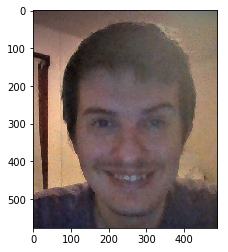

In [107]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
dog_breed_classifier('images/me.jpg')

This person looks like a Bull_terrier


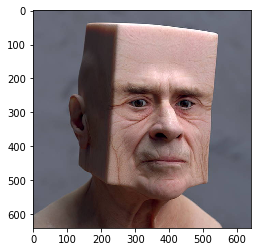

In [108]:
dog_breed_classifier('images/block_head.jpg')

This is a Saint_bernard


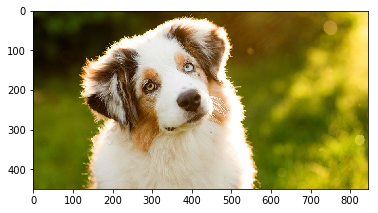

In [117]:
dog_breed_classifier('images/dog2.jpg')

Error: Your image does not contain a human or a dog.


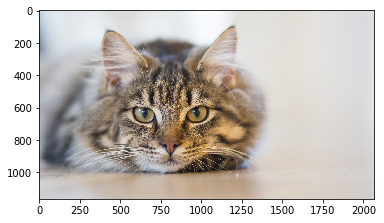

In [120]:
dog_breed_classifier('images/cat.jpeg')

This person looks like a Welsh_springer_spaniel


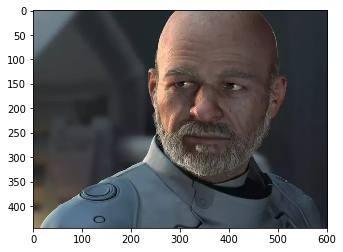

In [111]:
dog_breed_classifier('images/digital_human.png')

This is a Pomeranian


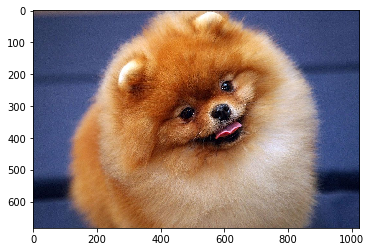

In [118]:
dog_breed_classifier('images/pomeranian.jpg')

This person looks like a Bull_terrier


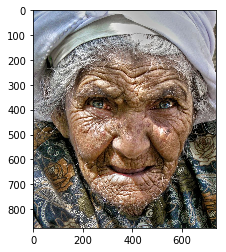

In [113]:
dog_breed_classifier('images/old_woman.jpg')

This is a Great_dane


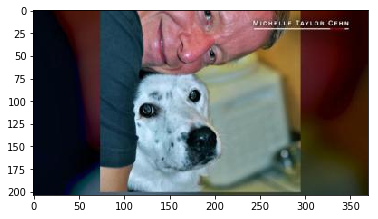

In [119]:
dog_breed_classifier('images/h_and_d.jpg')

This person looks like a Dachshund


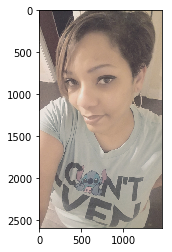

In [115]:
dog_breed_classifier('images/cathy_greg.jpg')